In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
word_subset = 5 # number of words to use as subset for ease

for w in words[:word_subset]:
    print(w)
    context = [0]*block_size
    # print(context)
    for ch in w+'.':
        ix=stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '----->', itos[ix])
        # print(context, '--->', ix)
        context = context[1:] + [ix]
        
X = torch.tensor(X)
Y = torch.tensor(Y)
# print(X)
# print(Y)



emma
... -----> e
..e -----> m
.em -----> m
emm -----> a
mma -----> .
olivia
... -----> o
..o -----> l
.ol -----> i
oli -----> v
liv -----> i
ivi -----> a
via -----> .
ava
... -----> a
..a -----> v
.av -----> a
ava -----> .
isabella
... -----> i
..i -----> s
.is -----> a
isa -----> b
sab -----> e
abe -----> l
bel -----> l
ell -----> a
lla -----> .
sophia
... -----> s
..s -----> o
.so -----> p
sop -----> h
oph -----> i
phi -----> a
hia -----> .


In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [7]:
embedding_dimension = 2
C = torch.randn((27, embedding_dimension))

In [11]:
C[X].shape

torch.Size([32, 3, 2])

In [29]:
# embedding for each context in X
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [34]:
W1 = torch.rand((6, 100))
b1 = torch.rand(100)

In [38]:
h = torch.tanh(emb.view(-1,6) @ W1 + b1)

In [39]:
h.shape

torch.Size([32, 100])

In [40]:
h

tensor([[ 0.0037, -0.1939, -0.0381,  ..., -0.4100,  0.7729,  0.1734],
        [-0.1557,  0.2963,  0.5446,  ...,  0.3785,  0.5799,  0.5518],
        [-0.1995,  0.6193,  0.6548,  ...,  0.6866,  0.4218,  0.8038],
        ...,
        [ 0.2324,  0.8300, -0.8367,  ...,  0.1587,  0.9545,  0.5502],
        [ 0.9866,  0.9744,  0.9997,  ...,  0.9978,  0.8392,  0.9954],
        [ 0.7758,  0.9807,  0.9162,  ...,  0.9271,  0.9603,  0.9900]])

In [41]:
W2 = torch.rand(100, 27)
b2 = torch.rand(27)

In [42]:
logits = h @ W2 + b2

In [43]:
logits.shape

torch.Size([32, 27])

In [44]:
counts = logits.exp()

In [45]:
probs = counts/counts.sum(1, keepdims=True)

In [46]:
probs.shape

torch.Size([32, 27])

In [47]:
probs[0].sum()

tensor(1.)

In [50]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [51]:
probs[0][5]

tensor(0.0400)

In [52]:
torch.arange(32)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [53]:
result = probs[torch.arange(32), Y]

In [54]:
loss = - result.log().mean()

In [55]:
loss

tensor(5.1609)

### Summarized Forward Pass

In [56]:
# build the dataset
def build_dataset(block_size, word_subset, verbose=False):
    X, Y = [], []

    for w in words[:word_subset]:
        if verbose:
            print(w)
        context = [0]*block_size
        # print(context)
        for ch in w+'.':
            ix=stoi[ch]
            X.append(context)
            Y.append(ix)
            if verbose:
                print(''.join(itos[i] for i in context), '----->', itos[ix])
            # print(context, '--->', ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [70]:
embedding_dimension = 2
neuron_second_layer = 100
block_size = 3
word_subset = len(words)
X, Y = build_dataset(block_size=block_size, word_subset=word_subset)
print("Input Shape -->", X.shape, Y.shape)


# generator for reproducable results
g = torch.Generator().manual_seed(2147483647)

# parameters
input_dim = embedding_dimension * block_size
C = torch.randn((27, embedding_dimension), generator=g)
W1 = torch.rand((input_dim, neuron_second_layer), generator=g)
b1 = torch.rand(neuron_second_layer, generator=g)
W2 = torch.rand((neuron_second_layer, 27), generator=g)
b2 = torch.rand(27, generator=g)
parameters = [C, W1, b1 , W2, b2]
print("# of Parameters -->", sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

Input Shape --> torch.Size([228146, 3]) torch.Size([228146])
# of Parameters --> 3481


In [71]:
for _ in range(100):
    #forward pass
    emb = C[X]
    h = torch.tanh(emb.view(-1, input_dim) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,Y)
    
    # backward pass
    for p in parameters:
        p.grad = None   # zero gradient
    loss.backward()  # calculate gradients
    for p in parameters:
        p.data += -0.01 * p.grad   # update parameters
print(loss)

tensor(3.5523, grad_fn=<NllLossBackward0>)


### Use minibatch to speed up

Randomly select a portion of dataset and do forward backward pass and update only on partial dataset

Gradient direction is good enough even if estimation on small example.
It is much better to have approximate gradient and take more steps than evaluate full gradient and take few steps

In [86]:
for _ in range(1000):
    
    #minibatch construct
    ix = torch.randint(0, X.shape[0], (32, ))
    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, input_dim) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,Y[ix])
    # print("Loss --> ", loss.item())

    # backward pass
    for p in parameters:
        p.grad = None   # zero gradient
    loss.backward()  # calculate gradients
    for p in parameters:
        p.data += -0.001 * p.grad   # update parameters

print(loss)

tensor(2.4040, grad_fn=<NllLossBackward0>)


In [87]:
# Loss on full dataset
emb = C[X]
h = torch.tanh(emb.view(-1, input_dim) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Y)
print(loss)
    

tensor(2.7480, grad_fn=<NllLossBackward0>)


# How to determine learning rate

In [88]:
# space exponentially in learning rate space
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [89]:
# reset parameters first
lri = []
lossi = []
for i in range(1000):
    
    #minibatch construct
    ix = torch.randint(0, X.shape[0], (32, ))
    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, input_dim) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,Y[ix])
    # print("Loss --> ", loss.item())

    # backward pass
    for p in parameters:
        p.grad = None   # zero gradient
    loss.backward()  # calculate gradients
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad   # update parameters
    # track stats
    lri.append(lre[i])  # append from exponent lr
    lossi.append(loss.item())

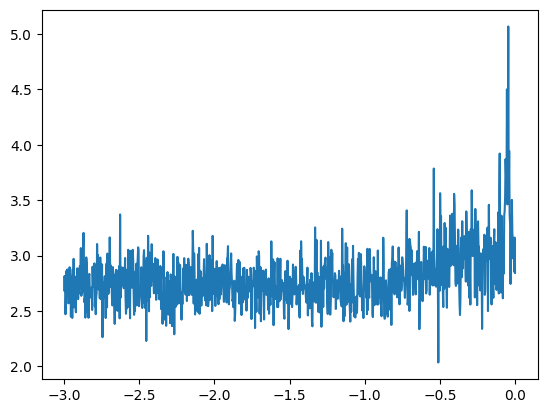

In [90]:
plt.plot(lri, lossi)

### Training 

In [91]:
embedding_dimension = 2
neuron_second_layer = 100
block_size = 3
word_subset = len(words)
X, Y = build_dataset(block_size=block_size, word_subset=word_subset)
print("Input Shape -->", X.shape, Y.shape)


# generator for reproducable results
g = torch.Generator().manual_seed(2147483647)

# parameters
input_dim = embedding_dimension * block_size
C = torch.randn((27, embedding_dimension), generator=g)
W1 = torch.rand((input_dim, neuron_second_layer), generator=g)
b1 = torch.rand(neuron_second_layer, generator=g)
W2 = torch.rand((neuron_second_layer, 27), generator=g)
b2 = torch.rand(27, generator=g)
parameters = [C, W1, b1 , W2, b2]
print("# of Parameters -->", sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

Input Shape --> torch.Size([228146, 3]) torch.Size([228146])
# of Parameters --> 3481


In [92]:
def train_model(n=1000, lr=0.1):
    for _ in range(n):

        #minibatch construct
        ix = torch.randint(0, X.shape[0], (32, ))
        # forward pass
        emb = C[X[ix]]
        h = torch.tanh(emb.view(-1, input_dim) @ W1 + b1)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits,Y[ix])
        # print("Loss --> ", loss.item())

        # backward pass
        for p in parameters:
            p.grad = None   # zero gradient
        loss.backward()  # calculate gradients
        for p in parameters:
            p.data += -lr * p.grad   # update parameters

    print(f'Full Dataset Loss: {training_loss()}')

In [93]:
# Loss on full dataset
def training_loss():
    emb = C[X]
    h = torch.tanh(emb.view(-1, input_dim) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,Y)
    return loss

In [94]:
train_model(n=10000)
train_model(n=10000)
train_model(n=10000)
train_model(n=10000, lr=0.01)
train_model(n=10000, lr=0.001)

Full Dataset Loss: 2.377793073654175
Full Dataset Loss: 2.3411765098571777
Full Dataset Loss: 2.33111834526062
Full Dataset Loss: 2.2538082599639893
Full Dataset Loss: 2.2483088970184326


### Data Split
Training Set, Dev/Validation Set, Test Set
80%, 10%, 10%

In [95]:
# build the dataset
def build_dataset(words, block_size=3,verbose=False):
    X, Y = [], []

    for w in words:
        if verbose:
            print(w)
        context = [0]*block_size
        # print(context)
        for ch in w+'.':
            ix=stoi[ch]
            X.append(context)
            Y.append(ix)
            if verbose:
                print(''.join(itos[i] for i in context), '----->', itos[ix])
            # print(context, '--->', ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [96]:
import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words=words[:n1])
Xdev, Ydev = build_dataset(words=words[n1:n2])
Xte, Yte = build_dataset(words=words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [97]:
embedding_dimension = 2
neuron_second_layer = 100

# generator for reproducable results
g = torch.Generator().manual_seed(2147483647)

# parameters
input_dim = embedding_dimension * block_size
C = torch.randn((27, embedding_dimension), generator=g)
W1 = torch.rand((input_dim, neuron_second_layer), generator=g)
b1 = torch.rand(neuron_second_layer, generator=g)
W2 = torch.rand((neuron_second_layer, 27), generator=g)
b2 = torch.rand(27, generator=g)
parameters = [C, W1, b1 , W2, b2]
print("# of Parameters -->", sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

# of Parameters --> 3481


In [98]:
def train_model(n=1000, lr=0.1, batch_size=32):
    for _ in range(n):

        #minibatch construct
        ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
        # forward pass
        emb = C[Xtr[ix]]
        h = torch.tanh(emb.view(-1, input_dim) @ W1 + b1)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits,Ytr[ix])
        # print("Loss --> ", loss.item())

        # backward pass
        for p in parameters:
            p.grad = None   # zero gradient
        loss.backward()  # calculate gradients
        for p in parameters:
            p.data += -lr * p.grad   # update parameters

    print(f'Traininig Loss: {training_loss()}')

In [99]:
# Loss on full dataset
def training_loss():
    emb = C[Xtr]
    h = torch.tanh(emb.view(-1, input_dim) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,Ytr)
    return loss

In [100]:
train_model(n=10000)

Traininig Loss: 2.397735595703125


In [101]:
# Evaluate loss on dev
def dev_loss():
    emb = C[Xdev]
    h = torch.tanh(emb.view(-1, input_dim) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,Ydev)
    return loss

In [102]:
dev_loss()

tensor(2.4032, grad_fn=<NllLossBackward0>)

In [103]:
# Evaluate loss on test
def test_loss():
    emb = C[Xte]
    h = torch.tanh(emb.view(-1, input_dim) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,Yte)
    return loss

### Scale Up

In [104]:
embedding_dimension = 2
neuron_second_layer = 300

# generator for reproducable results
g = torch.Generator().manual_seed(2147483647)

# parameters
input_dim = embedding_dimension * block_size
C = torch.randn((27, embedding_dimension), generator=g)
W1 = torch.rand((input_dim, neuron_second_layer), generator=g)
b1 = torch.rand(neuron_second_layer, generator=g)
W2 = torch.rand((neuron_second_layer, 27), generator=g)
b2 = torch.rand(27, generator=g)
parameters = [C, W1, b1 , W2, b2]
print("# of Parameters -->", sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

# of Parameters --> 10281


In [105]:
train_model(n=40000)

Traininig Loss: 2.3593413829803467


In [106]:
train_model(n=40000, lr=0.001)

Traininig Loss: 2.2668662071228027


In [107]:
train_model(n=40000, lr=0.0001)

Traininig Loss: 2.2657241821289062


In [108]:
dev_loss()

tensor(2.2722, grad_fn=<NllLossBackward0>)

In [111]:
# increasing batchsize could also help so we are not thrasing too much

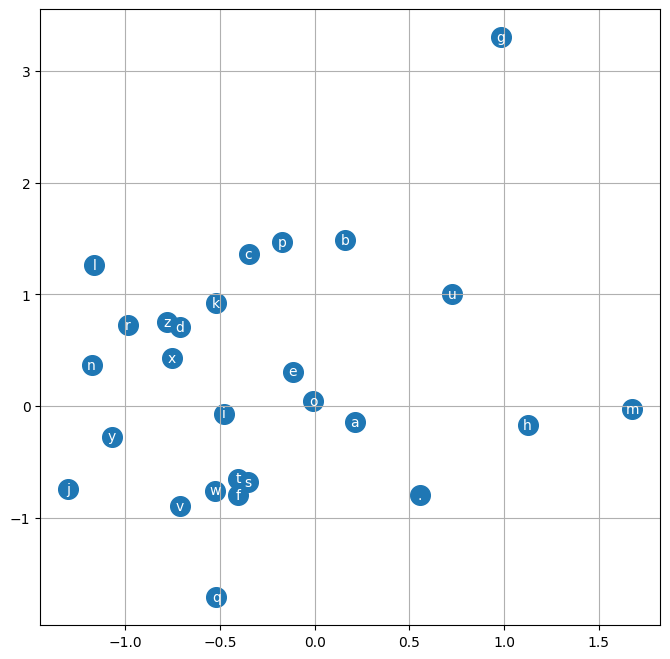

In [109]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(),C[i,1].item(), itos[i], ha="center", va="center", color="white") 
plt.grid('minor')

In [119]:
# scale empbedding size

In [110]:
embedding_dimension = 20
neuron_second_layer = 500

# generator for reproducable results
g = torch.Generator().manual_seed(2147483647)

# parameters
input_dim = embedding_dimension * block_size
C = torch.randn((27, embedding_dimension), generator=g)
W1 = torch.rand((input_dim, neuron_second_layer), generator=g)
b1 = torch.rand(neuron_second_layer, generator=g)
W2 = torch.rand((neuron_second_layer, 27), generator=g)
b2 = torch.rand(27, generator=g)
parameters = [C, W1, b1 , W2, b2]
print("# of Parameters -->", sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

# of Parameters --> 44567


In [111]:
train_model(n=40000, batch_size=64)


Traininig Loss: 2.1369121074676514


In [112]:
train_model(n=40000, lr=0.001, batch_size=64)

Traininig Loss: 2.0076897144317627


In [113]:
train_model(n=40000, lr=0.0001, batch_size=64)

Traininig Loss: 2.0060763359069824


In [114]:
dev_loss()

tensor(2.0914, grad_fn=<NllLossBackward0>)

In [115]:
test_loss()

tensor(2.0865, grad_fn=<NllLossBackward0>)

# Sampling from Model. Inference

In [169]:
# g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor(context)]

        h = torch.tanh(emb.view(1, -1)@W1+b1)

        logits = h @ W2 + b2

        probs = F.softmax(logits, dim=1)

        ix = torch.multinomial(probs, num_samples=1, generator=None).item()

        context = context[1:]+[ix]

        out.append(ix)
        if ix==0:
            break
    print(''.join(itos[i] for i in out))
        

ezra.
heryn.
trick.
halilian.
coda.
jena.
jaique.
ravyoon.
alan.
by.
kelayten.
joceson.
shon.
delindelinsole.
feliam.
emere.
marafianson.
mah.
santhani.
torine.
